In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import os
import re
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram

In [2]:
funded_R01_projects = pd.DataFrame()
for root, dirs, files in os.walk("data/funded_R01_projects_category_dfs/cleaned/", topdown=True):
    for file in files:
        df = pd.read_csv(os.path.join(root, file))
        funded_R01_projects = funded_R01_projects.append(df)

success_rate_combined = pd.DataFrame()
for root, dirs, files in os.walk("data/original_data/Success_data", topdown=True):
    for file in files:
        df = pd.read_html(os.path.join(root, file), header = 0)[0]
        success_rate_combined = success_rate_combined.append(df)
        
nih_budget = pd.read_csv("data/nih_budget_full.csv")
inflation = pd.read_excel("data/SeriesReport-20180718142529_be797a.xlsx", skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12])
overall_success_rate = pd.read_csv("data/success_rate/T218_Success_Rates_RPG_and_R01_Eq_1_clean.csv")

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,11,12,15,19,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,11,12,15,17,19,24,26,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sns.set_style("darkgrid")

In [4]:
nih_budget_1985 = nih_budget[(nih_budget.FY >= 1985) & (nih_budget.FY < 2018)]
nih_budget_1985.reset_index(drop = True, inplace = True)
nih_budget_1985_totals = nih_budget_1985.Total.tolist()

In [5]:
nih_budget_in_1985 = nih_budget_1985.Total.iloc[0]

In [6]:
inflation_per_year = inflation.Annual.tolist()[:-1]

In [7]:
projected_budgets = [nih_budget_in_1985]
for i in inflation_per_year:
    projected_budgets.append(projected_budgets[-1] * i)

In [8]:
years = []
categories = []
for year in np.sort(funded_R01_projects.FY.unique())[:-1]:
    df_year = funded_R01_projects[funded_R01_projects.FY == year]
    num_categories = len(df_year.category.unique())
    categories.append(num_categories)
    years.append(year)

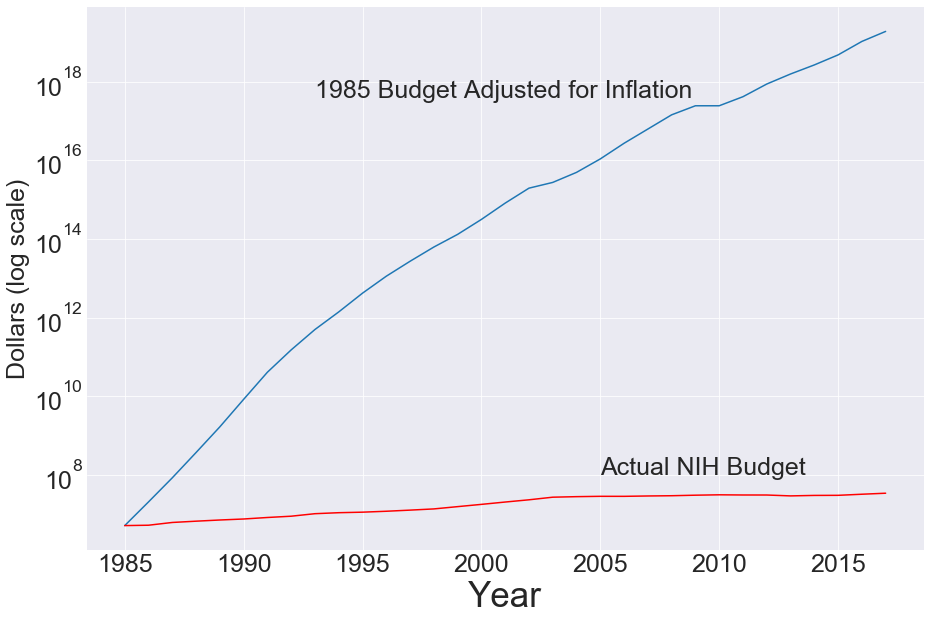

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(years, projected_budgets)
plt.plot(years, nih_budget_1985_totals, color = "red")
plt.yscale("log")
plt.xlabel('Year', fontsize = 35)
plt.ylabel('Dollars (log scale)', fontsize = 25)
plt.text(s = "1985 Budget Adjusted for Inflation", x = 1993, y = 10**17.6, size = 25)
plt.text(s = "Actual NIH Budget", x = 2005, y = 10**8, size = 25)
ax.tick_params(axis='both', labelsize = 25)
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([]);

#plt.tight_layout()
#plt.savefig("data/figs_for_pres/inflation_zoom.png", dpi=80, orientation='landscape')

In [10]:
overall_success_rate["Number of R01 Equivalent Grants Applications Reviewed"] = overall_success_rate["Number of R01 Equivalent Grants Applications Reviewed"].str.replace("\t", "").str.replace(",", "").astype(int)

In [11]:
overall_success_rate["Number of R01 Equivalent Grants Applications Awarded"] = overall_success_rate["Number of R01 Equivalent Grants Applications Awarded"].str.replace("\t", "").str.replace(",", "").astype(int)

In [12]:
overall_success_rate["Success Rate R01 Equivalent Grants"] = overall_success_rate["Success Rate R01 Equivalent Grants"].str.replace("%", "").astype(float)

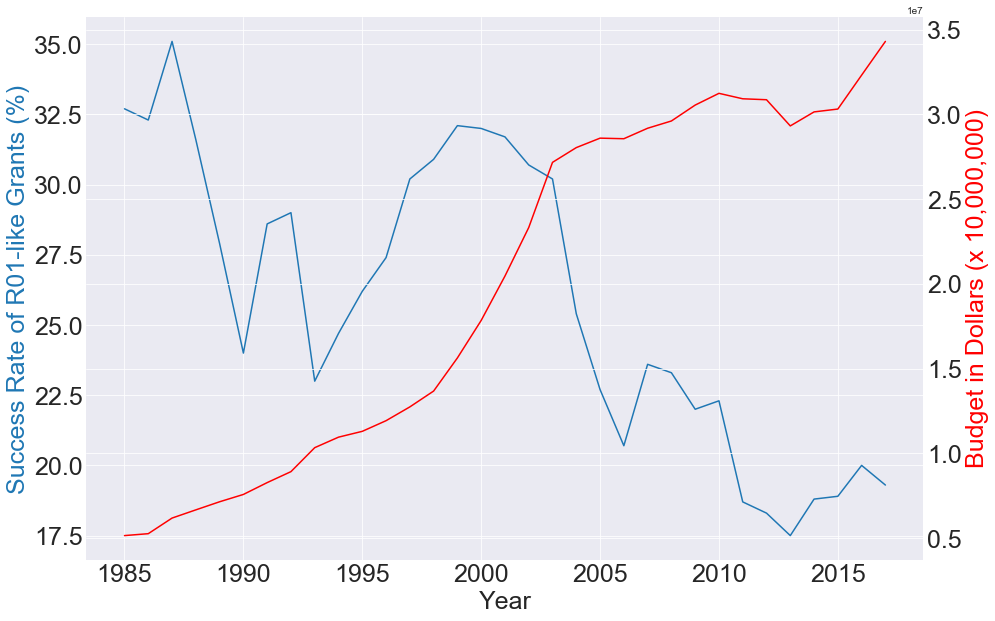

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years, overall_success_rate.loc[overall_success_rate.FY >= 1985]["Success Rate R01 Equivalent Grants"], color = "C0")
ax2.plot(years, nih_budget_1985_totals, color = "red")
ax.set_xlabel('Year', fontsize = 25)
ax.set_ylabel('Success Rate of R01-like Grants (%)', fontsize = 25, color = "C0")
ax2.set_ylabel('Budget in Dollars (x 10,000,000)', fontsize = 25, color = "red")
ax.tick_params(axis='both', labelsize = 25)
ax2.tick_params(labelsize = 25);
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])
#ax2.get_yaxis().set_ticks([]);

#plt.tight_layout()
#plt.savefig("data/figs_for_pres/success_rate_zoom.png", dpi=80, orientation='landscape')

In [14]:
R01s_per_year = funded_R01_projects.groupby("FY").nunique()

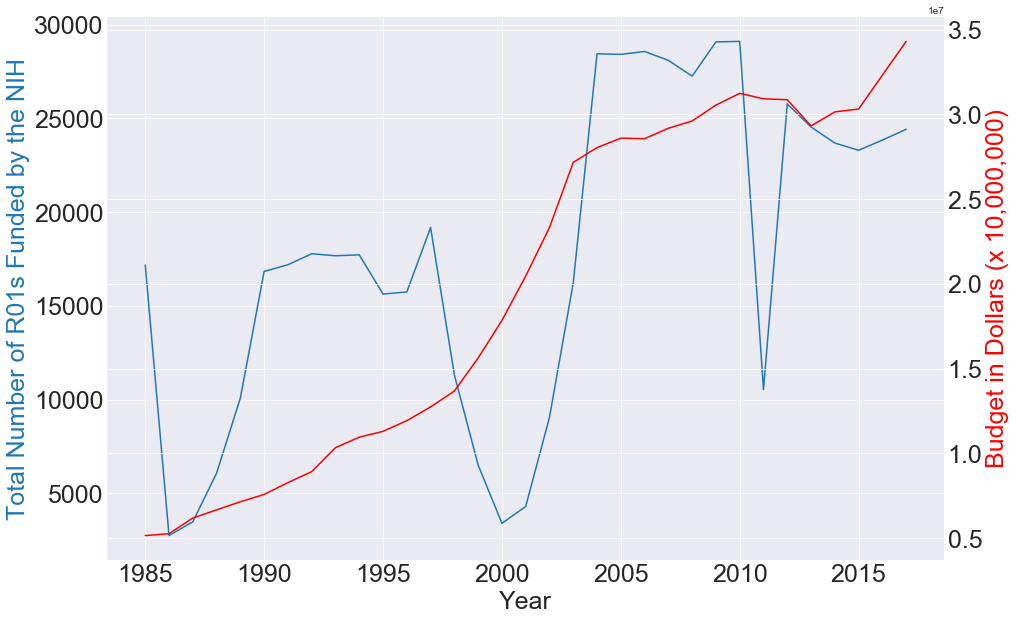

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years, R01s_per_year.loc[R01s_per_year.index != 2018.0]["grant_num"])
#ax.plot(years, overall_success_rate[overall_success_rate.FY >= 1985]["Number of R01 Equivalent Grants Applications Reviewed"])
ax2.plot(years, nih_budget_1985_totals, color = "red")
ax.set_xlabel('Year', fontsize = 25)
ax.set_ylabel('Total Number of R01s Funded by the NIH', fontsize = 25, color = "C0")
ax2.set_ylabel('Budget in Dollars (x 10,000,000)', fontsize = 25, color = "red")
ax.tick_params(axis='both', labelsize = 25)
ax2.tick_params(labelsize = 25);

#plt.tight_layout()
#plt.savefig("data/figs_for_pres/budget_number-of-grants_zoom.png", dpi=80, orientation='landscape')

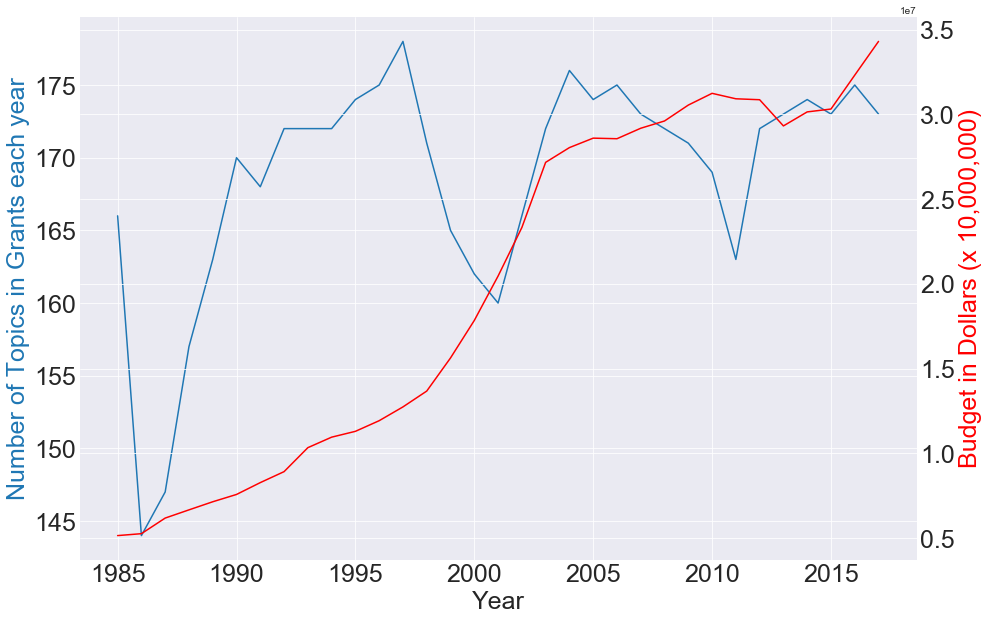

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years, categories)
ax2.plot(years, nih_budget_1985_totals, color = "red")
ax.set_xlabel('Year', fontsize = 25)
ax.set_ylabel('Number of Topics in Grants each year', fontsize = 25, color = "C0")
ax2.set_ylabel('Budget in Dollars (x 10,000,000)', fontsize = 25, color = "red")
ax.tick_params(axis='both', labelsize = 25)
ax2.tick_params(labelsize = 25);

#plt.tight_layout()
#plt.savefig("data/figs_for_pres/budget_number-of-topics.png", dpi=80, orientation='landscape')

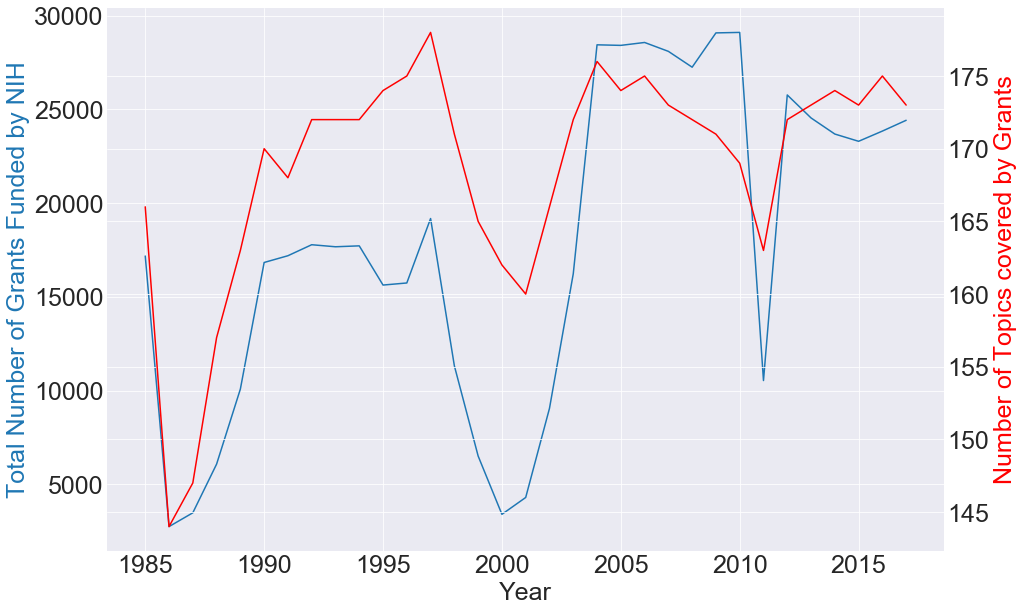

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(R01s_per_year.loc[R01s_per_year.index != 2018.0]["grant_num"])
ax2.plot(years, categories, color = "red")
ax.set_xlabel('Year', fontsize = 25)
ax.set_ylabel('Total Number of Grants Funded by NIH', fontsize = 25, color = "C0")
ax2.set_ylabel('Number of Topics covered by Grants', fontsize = 25, color = "red")
ax.tick_params(axis='both', labelsize = 25)
ax2.tick_params(labelsize = 25);

#plt.tight_layout()
#plt.savefig("data/figs_for_pres/grants_topics.png", dpi=80, orientation='landscape')

In [18]:
example_df = funded_R01_projects[['FY', 'ABSTRACT_TEXT', 'grant_num', 'category', 'probability']].iloc[[1, 8, 12, 16, 18, 19]]
#example_df.to_csv("data/figs_for_pres/example_df.csv")
example_df

,FY,ABSTRACT_TEXT,grant_num,category,probability
1,2017.0,Summary Brain-computer interface (BCI) tec...,R01AT009263,Bipolar Disorder,1.000000
8,2018.0,"Many studies, including some by the PI, reveal...",R01HD090068,Pediatric,1.000000
12,2018.0,Liver disease is currently the most common cau...,R01AI134630,Chronic Liver Disease and Cirrhosis,1.000000
16,2018.0,Gram-negative bacteria utilize extracellular f...,R01DK108840,Infectious Diseases,1.000000
18,2018.0,Abstract Myocardial infarction (MI) is caused ...,R01HL136025,Regenerative Medicine,0.999998
19,2018.0,The role of Lung Surfactant (LS) in lowering t...,R01HL051177,Acute Respiratory Distress Syndrome,0.999681


In [19]:
# split df into before and after 2003, 2003 goes with before
before_2003 = funded_R01_projects[funded_R01_projects.FY <= 2003]
after_2003 = funded_R01_projects[funded_R01_projects.FY > 2003]

In [20]:
before_2003_category_counts = pd.DataFrame(before_2003.category.value_counts()).reset_index()
after_2003_category_counts = after_2003.category.value_counts()
after_2003_category_counts = pd.DataFrame(after_2003_category_counts.append(pd.Series(0, index=["Fetal Alcohol Syndrome"]))).reset_index()

In [21]:
after_2003_category_counts.columns = ["category", "count"]
after_2003_category_counts["label"] = "after"
after_2003_category_counts["norm_counts"] = after_2003_category_counts["count"]/len(after_2003)

In [22]:
before_2003_category_counts.columns = ["category", "count"]
before_2003_category_counts["label"] = "before"
before_2003_category_counts["norm_counts"] = before_2003_category_counts["count"]/len(before_2003)

In [23]:
category_counts_before_after = pd.concat([before_2003_category_counts, after_2003_category_counts])

In [24]:
category_counts_before_after_wide = before_2003_category_counts[["category", "count", "norm_counts"]].merge(after_2003_category_counts[["category", "count", "norm_counts"]], how = "inner", on = "category", suffixes = ["_before", "_after"])
category_counts_before_after_wide.drop(category_counts_before_after_wide[category_counts_before_after_wide.category.isin(["Fetal Alcohol Syndrome", "Suicide", "Injury - Unintentional Childhood Injury"])].index, inplace = True)

In [25]:
category_counts_before_after_wide["fold_change"] = ((category_counts_before_after_wide["norm_counts_after"]-category_counts_before_after_wide["norm_counts_before"])/category_counts_before_after_wide["count_before"])*10000000
category_counts_before_after_wide["absolute_change"] = abs(category_counts_before_after_wide["fold_change"])

In [26]:
bottom_10_fold_change = category_counts_before_after_wide.sort_values("fold_change").head(5)
top_10_fold_change = category_counts_before_after_wide.sort_values("fold_change").tail(5)
#top_bottom_10_fc = bottom_10_fold_change.append(top_10_fold_change)

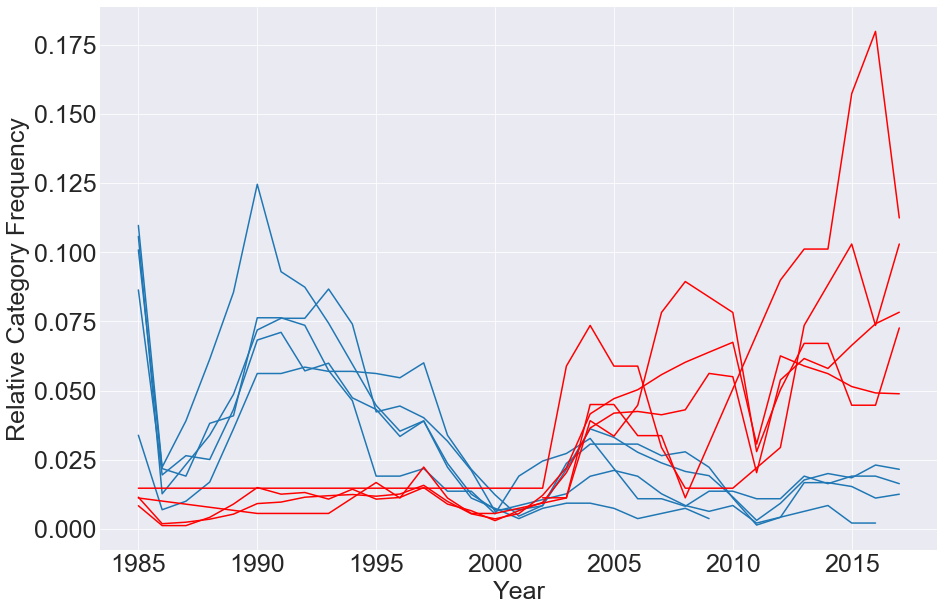

In [27]:
# Graph shows top 5 increased and decreased. Can see things that were high before 2003 were low after and vice versa

fig, ax = plt.subplots(figsize=(15, 10))
for cat in bottom_10_fold_change.category:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").nunique()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"]/len(df), color = "C0")
for cat in top_10_fold_change.category:
    df = funded_R01_projects[funded_R01_projects.category == cat]
    cats_per_year = df.groupby("FY").nunique()
    plt.plot(cats_per_year[cats_per_year.index != 2018.0]["grant_num"]/len(df), color = "red")
plt.ylabel("Relative Category Frequency", size = 25)
plt.xlabel("Year", size = 25)
ax.tick_params(axis='both', labelsize = 25)
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([]);

#plt.tight_layout()
#plt.savefig("data/figs_for_pres/sum_fig.png", dpi=80, orientation='landscape')

In [28]:
cat_freq_per_year = []
for cat in funded_R01_projects.category.unique():
    sub_df = funded_R01_projects[funded_R01_projects.category == cat]
    year_freq = []
    for year in funded_R01_projects.FY.unique():
        year_freq.append(len(sub_df[sub_df.FY == year])/len(funded_R01_projects[funded_R01_projects.FY == year]))
    cat_freq_per_year.append(year_freq)

In [29]:
cat_freq_array = np.array(cat_freq_per_year)
cat_freq_df = pd.DataFrame(cat_freq_array)
cat_freq_df.columns = funded_R01_projects.FY.unique()
cat_freq_df.index = funded_R01_projects.category.unique()

In [30]:
# try using scipy, looks like it can do unsupervised

y = pdist(cat_freq_df, 'euclidean')

z = linkage(y, method='ward', metric='euclidean')

fclust = fcluster(z, t = 1.11, criterion = 'inconsistent')

In [31]:
#Counter(fclust)
assignments = []
clusters = set(fclust)
for clust in clusters:
    inds_in_cat = [ind for ind, val in enumerate(fclust) if val == clust]
    topics_in_cat = cat_freq_df.iloc[inds_in_cat].index.tolist()
    assignments.append(topics_in_cat)

In [32]:
def graph_category_cluster(l):
    
    fig, ax = plt.subplots(figsize=(15, 10))
    for cat in l:
        df = funded_R01_projects[funded_R01_projects.category == cat]
        cats_per_year = df.groupby("FY").nunique()
        years_2018 = np.array(years)
        grants_per_year_cat = []
        for year in years_2018:
            if year in cats_per_year.index:
                grants_per_year_cat.append(cats_per_year[cats_per_year.index == year]["grant_num"].values[0])
            else:
                grants_per_year_cat.append(0)
        grants_per_year_cat_array = np.array(grants_per_year_cat)
        grants_per_year = np.array([len(funded_R01_projects[funded_R01_projects.FY == year]) for year in years_2018])
        norm_grants_per_year = (grants_per_year_cat_array/grants_per_year)
        plt.plot(years_2018, norm_grants_per_year)
    plt.axvline(x=2003, color = "red")
    #plt.title(', '.join(l), size = 15, wrap = True)
    plt.ylabel("Relative Frequency per Year", size = 25)
    plt.xlabel("Year", size = 25)
    ax.tick_params(axis='both', labelsize = 25)
    #ax.get_yaxis().set_ticks([])
    #ax.get_xaxis().set_ticks([]);

In [33]:
example_clusters = [11, 34, 14, 23] 

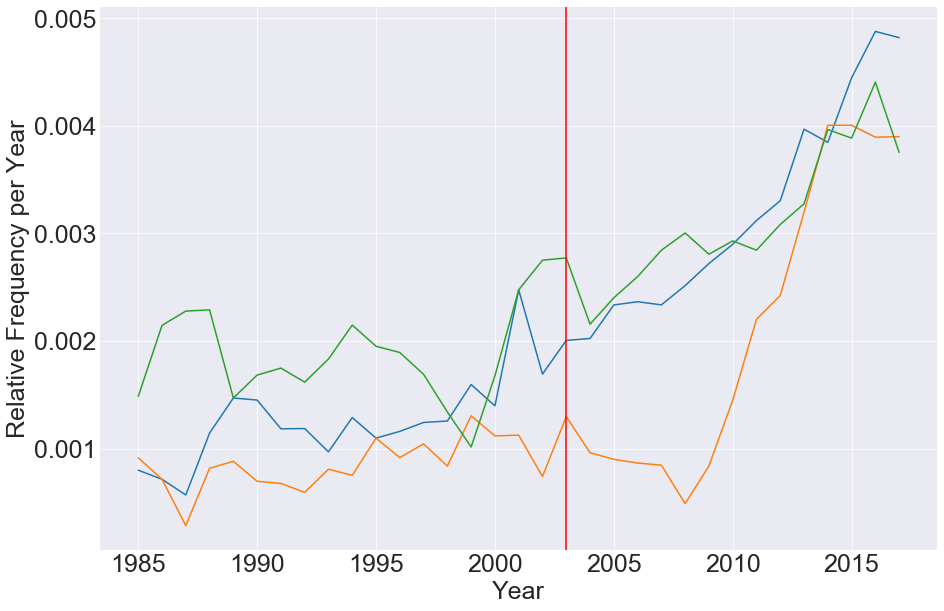

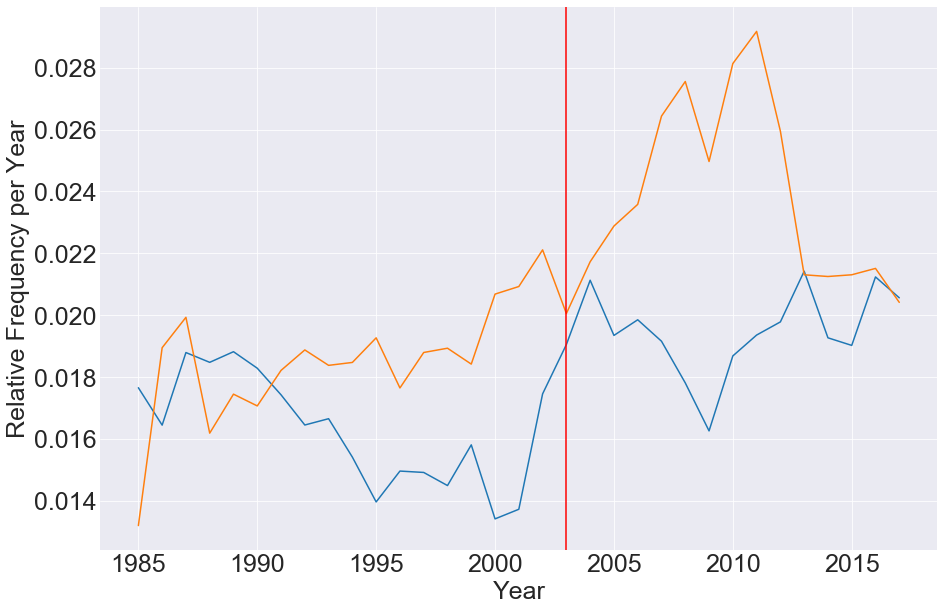

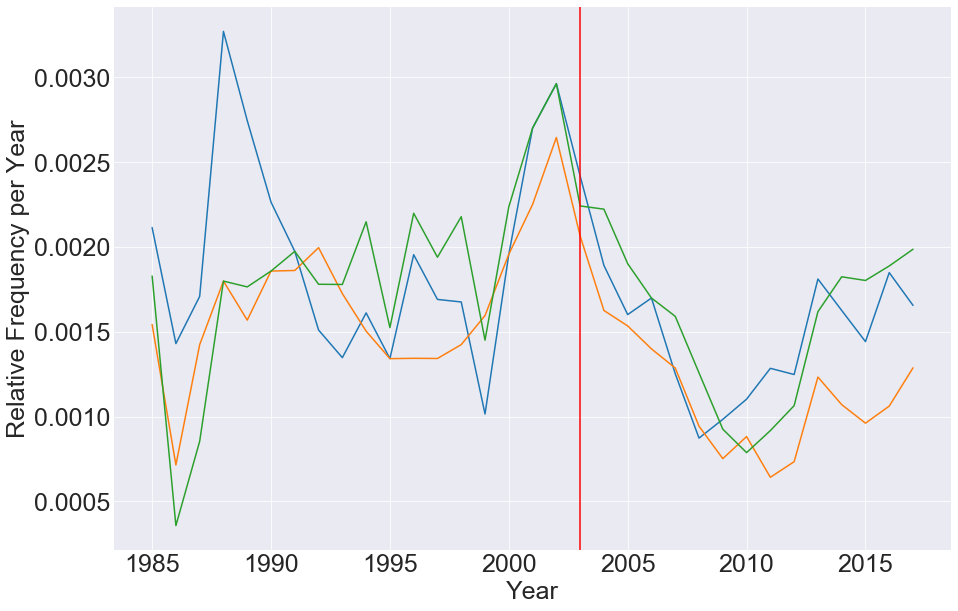

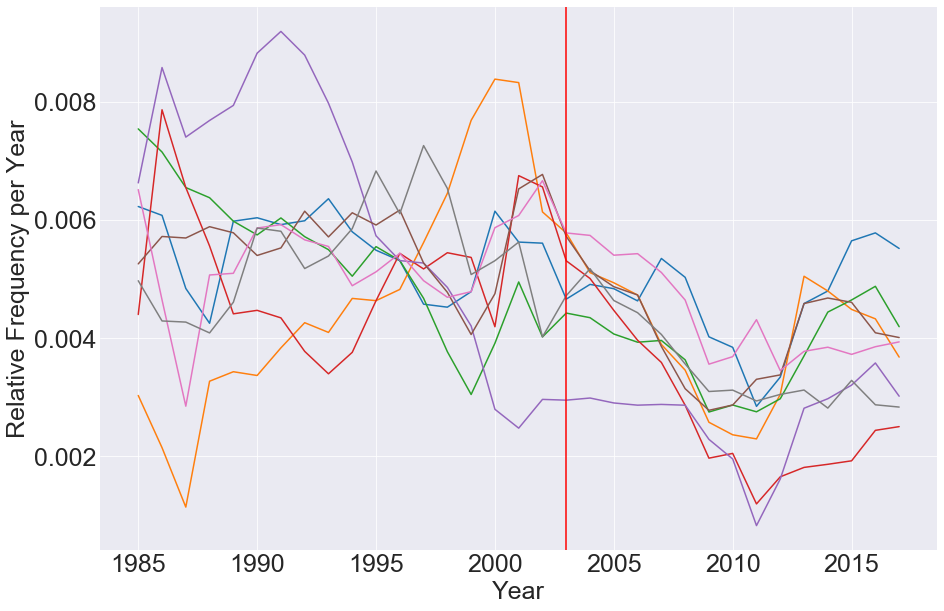

In [34]:
for c in example_clusters:
    graph_category_cluster(assignments[c])
    
    #plt.tight_layout()
    #plt.savefig("data/figs_for_pres/example_cluster_{}.png".format(c), dpi=80, orientation='landscape')

In [35]:
for c in example_clusters:
    print(assignments[c])

['Autism', 'Pancreatic Cancer', 'Fragile X Syndrome']
['Heart Disease - Coronary Heart Disease', 'Neurodegenerative']
['Osteoarthritis', 'Down Syndrome', 'Muscular Dystrophy']
['Assistive Technology', 'Rheumatoid Arthritis', 'Dietary Supplements', 'ALS', 'Human Genome', 'Vector-Borne Diseases', 'Dental_Oral and Craniofacial Disease', 'Violence Research']


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

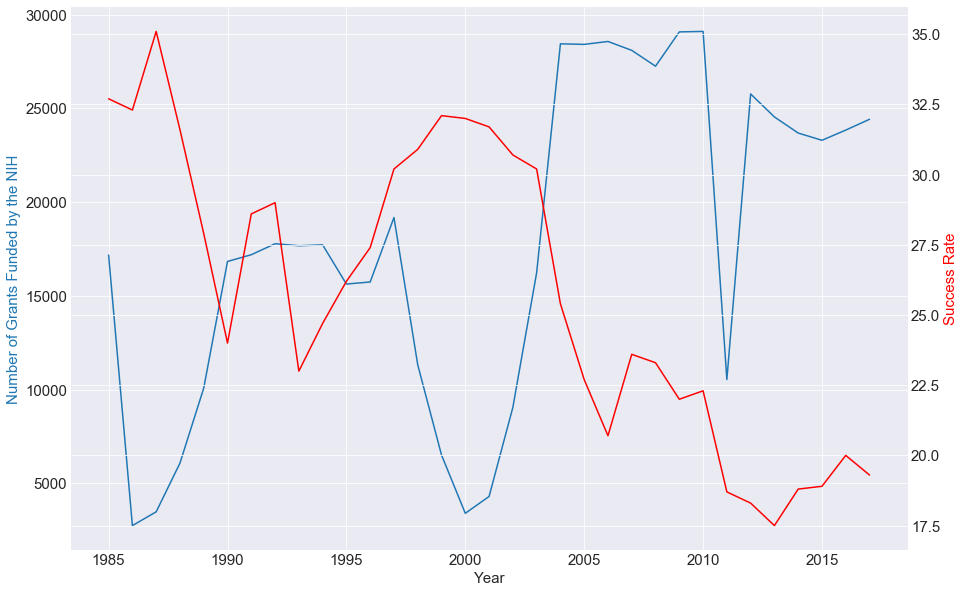

In [62]:
# Figure out how to account for this difference in analysis/plots
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years, R01s_per_year.loc[R01s_per_year.index != 2018.0]["grant_num"])
ax2.plot(years, overall_success_rate.loc[overall_success_rate.FY >= 1985]["Success Rate R01 Equivalent Grants"], color = "red")
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Number of Grants Funded by the NIH', fontsize = 15, color = "C0")
ax2.set_ylabel('Success Rate', fontsize = 15, color = "red")
ax.tick_params(axis='both', labelsize = 15)
ax2.tick_params(labelsize = 15);

# <s>Sentence</s> Graph Graveyard

In [67]:
# fig, ax = plt.subplots(figsize=(15, 10))
# plt.plot(R01s_per_year.loc[R01s_per_year.index != 2018.0]["grant_num"])
# plt.xlabel("Year", size = 20)
# plt.ylabel("Number of Grants Funded by NIH", size = 20)
# ax.tick_params(axis='both', labelsize = 15)
# plt.show();

In [174]:
# fig, ax = plt.subplots(figsize=(20, 20))
# dendrogram(z)
# ax.tick_params(axis='both', labelsize = 15);

In [173]:
# for l in assignments[1:]:
#     graph_category_cluster(l)

In [18]:
R01_success_rate = success_rate_combined[success_rate_combined["Activity Code"] == "R01"]

In [19]:
R01_success_rate["success_rate"] = (R01_success_rate["Number of Applications Awarded"]/R01_success_rate["Number of Applications Reviewed"])*100

/Users/maheshrao/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
new_R01_success_rate = R01_success_rate[R01_success_rate["Award Type"] == "New"].sort_values("Fiscal Year")

In [21]:
renew_R01_success_rate = R01_success_rate[R01_success_rate["Award Type"] == "Renewal"].sort_values("Fiscal Year")

In [22]:
supplement_R01_success_rate = R01_success_rate[R01_success_rate["Award Type"] == "Supplement"].sort_values("Fiscal Year")

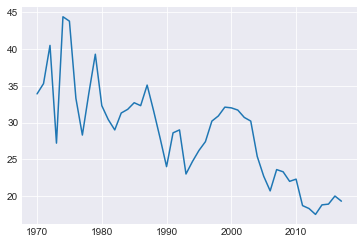

In [26]:
plt.plot(overall_success_rate.FY, overall_success_rate["Success Rate R01 Equivalent Grants"])

In [29]:
annual_success_rates = []
for df in [new_R01_success_rate, renew_R01_success_rate, supplement_R01_success_rate]:
    df_sum = df.groupby("Fiscal Year").sum()
    df_sum["success_rate"] = (df_sum["Number of Applications Awarded"]/df_sum["Number of Applications Reviewed"])*100
    annual_success_rates.append(df_sum.success_rate.tolist())

In [30]:
success_rate_years = new_R01_success_rate.groupby("Fiscal Year").count().index.tolist()

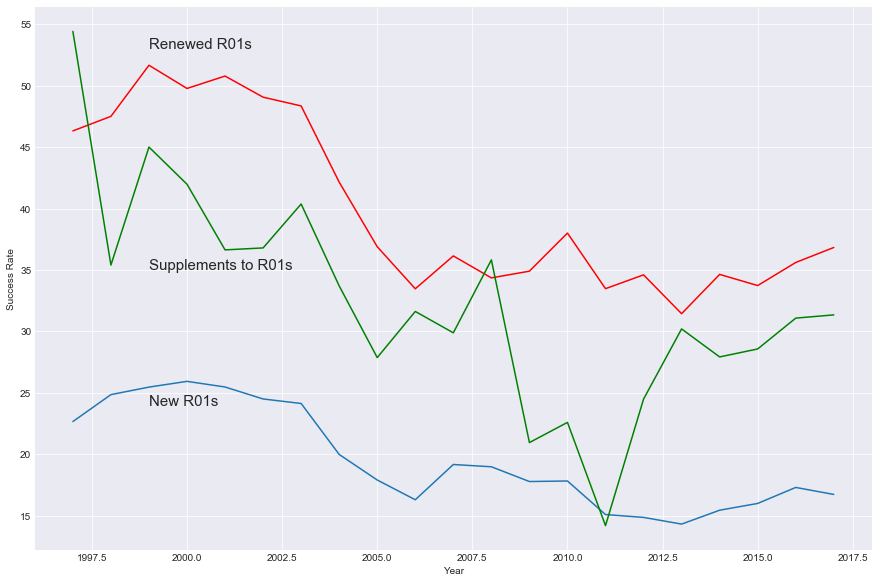

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(success_rate_years, annual_success_rates[0])
plt.plot(success_rate_years, annual_success_rates[1], color = "red")
plt.plot(success_rate_years, annual_success_rates[2], color = "green")
plt.ylabel("Success Rate")
plt.xlabel("Year")
plt.text(s = "New R01s", x = 1999, y = 24, size = 15)
plt.text(s = "Renewed R01s", x = 1999, y = 53, size = 15)
plt.text(s = "Supplements to R01s", x = 1999, y = 35, size = 15);

In [32]:
rows = {"years":years, "categories":categories, "budget_totals":nih_budget_1985_totals}

In [33]:
regression_df = pd.DataFrame(rows)

In [37]:
sequestration = ["pre"]*19 + ["post"]*14

In [38]:
regression_df["sequestration"] = sequestration

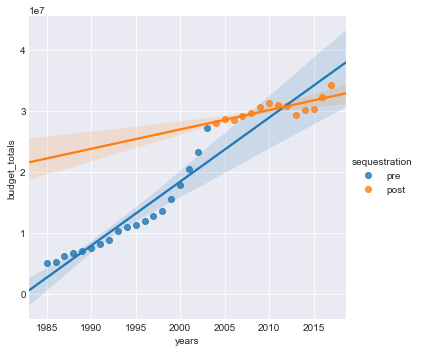

In [41]:
sns.lmplot(x="years", y="budget_totals", hue="sequestration", data=regression_df);

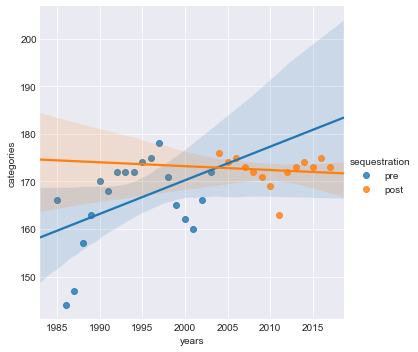

In [42]:
sns.lmplot(x="years", y="categories", hue="sequestration", data=regression_df);

In [43]:
success_rate = overall_success_rate.loc[overall_success_rate.FY >= 1985]["Success Rate R01 Equivalent Grants"].tolist()

In [44]:
regression_df["success_rate"] = success_rate

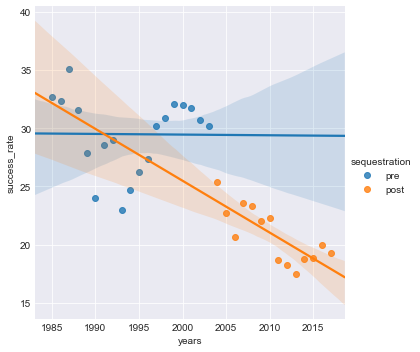

In [45]:
sns.lmplot(x="years", y="success_rate", hue="sequestration", data=regression_df);

In [46]:
success_rate_df_status = pd.DataFrame()
annual_success_rates = []
for status, df in zip(["new", "renew", "supplement"], [new_R01_success_rate, renew_R01_success_rate, supplement_R01_success_rate]):
    df_sum = df.groupby("Fiscal Year").sum()
    df_sum["success_rate"] = (df_sum["Number of Applications Awarded"]/df_sum["Number of Applications Reviewed"])*100
    df_sum["status"] = status
    success_rate_df_status = success_rate_df_status.append(df_sum)
success_rate_df_status.reset_index(inplace = True)

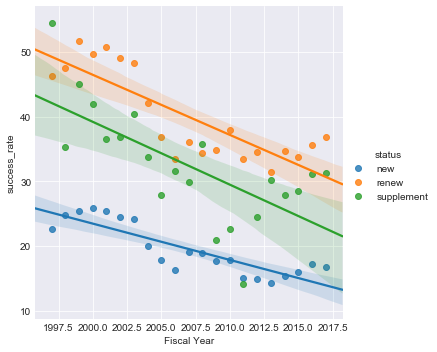

In [47]:
sns.lmplot(x="Fiscal Year", y="success_rate", hue="status", data=success_rate_df_status);

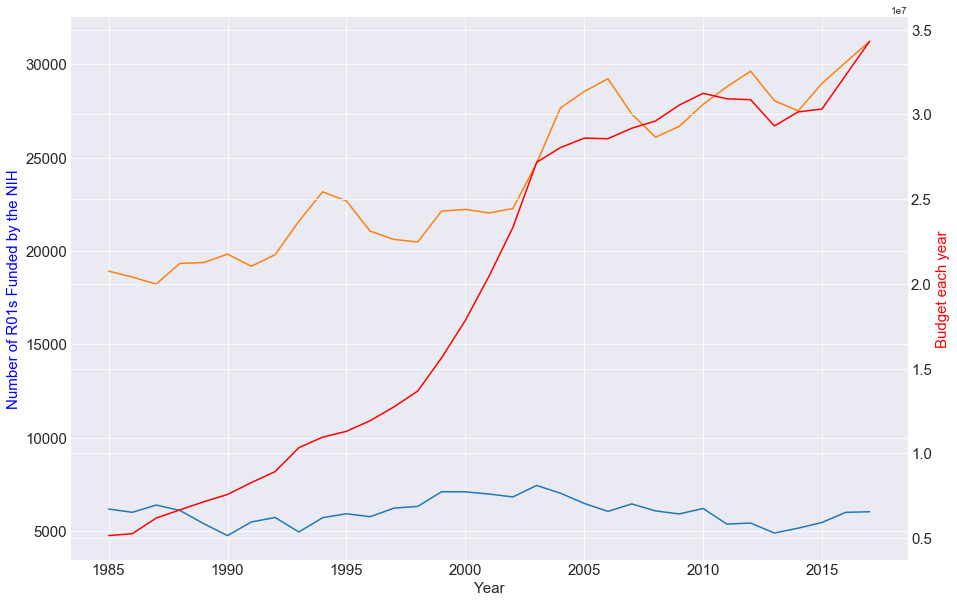

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()
ax.plot(years, overall_success_rate[overall_success_rate.FY >= 1985]["Number of R01 Equivalent Grants Applications Awarded"])
ax.plot(years, overall_success_rate[overall_success_rate.FY >= 1985]["Number of R01 Equivalent Grants Applications Reviewed"])
ax2.plot(years, nih_budget_1985_totals, color = "red")
#ax2.plot(years, overall_success_rate.loc[overall_success_rate.FY >= 1985]["Success Rate R01 Equivalent Grants"], color = "red")
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Number of R01s Funded by the NIH', fontsize = 15, color = "blue")
ax2.set_ylabel('Budget each year', fontsize = 15, color = "red")
ax.tick_params(axis='both', labelsize = 15)
ax2.tick_params(labelsize = 15);

In [25]:
category_counts_before_after_big_changes = category_counts_before_after[category_counts_before_after.category.isin(top_bottom_10_fc.category)]

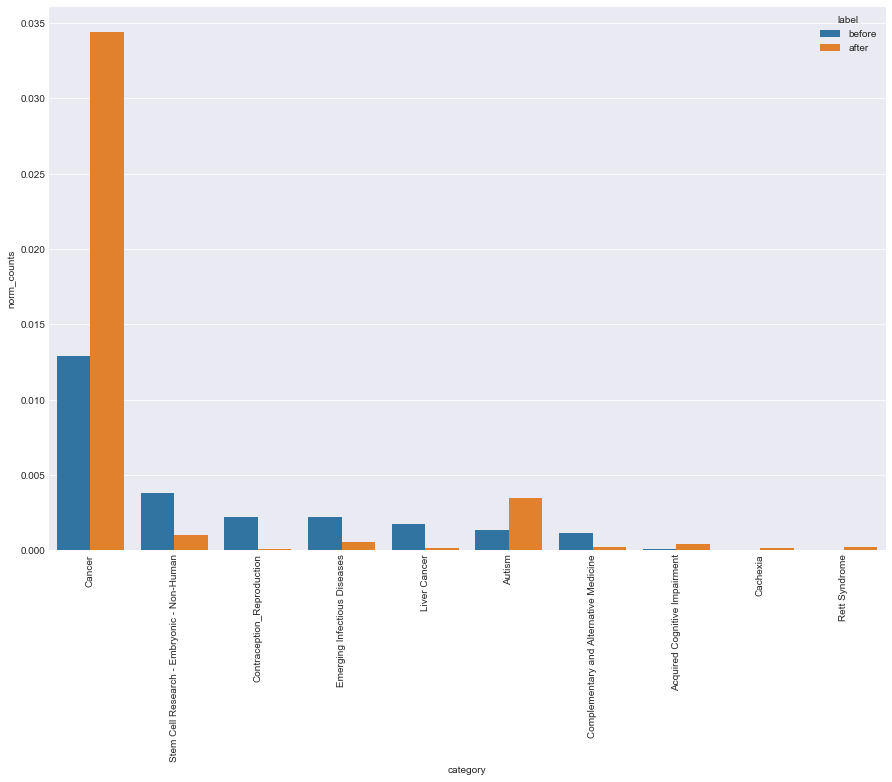

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = "category", y = "norm_counts", hue = "label", data = category_counts_before_after_big_changes)
plt.xticks(rotation='vertical');

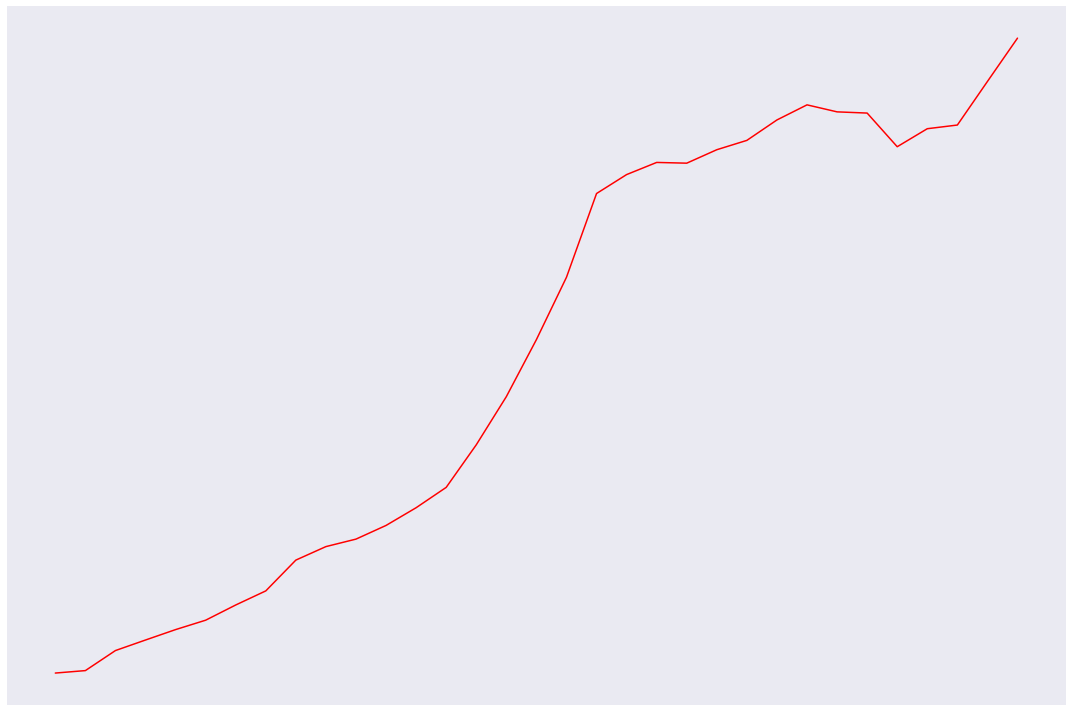

In [146]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(years, nih_budget_1985_totals, color = "red")
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([]);

plt.tight_layout()
plt.savefig("data/figs_for_pres/budget.png", dpi=80, orientation='landscape')